In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [32]:
df = pd.read_csv("RELIANCE.NS.csv")

In [33]:
# Drop any missing values
df.dropna(inplace=True)

# Convert the 'Date' column to a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date
df.sort_values('Date', inplace=True)

# Select the 'Close' column as the target variable
target_col = 'Close'

# Define the sliding window size
window_size = 250

In [34]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-05-03,397.729919,404.119354,393.717957,396.491669,369.337555,5961256.0
1,2013-05-06,397.333679,408.601868,397.333679,406.942596,379.072693,4318845.0
2,2013-05-07,406.893066,414.025452,405.976746,410.186829,382.094757,7628531.0
3,2013-05-08,411.152679,412.539551,407.165466,410.929810,382.786896,5472648.0
4,2013-05-09,410.310669,411.920410,403.673584,405.209015,377.457886,3776240.0


In [35]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2462,2023-04-25,2366.000000,2380.600098,2350.500000,2376.050049,2376.050049,4262471.0
2463,2023-04-26,2379.000000,2386.100098,2354.050049,2362.100098,2362.100098,3977129.0
2464,2023-04-27,2375.000000,2384.000000,2364.000000,2377.050049,2377.050049,4230627.0
2465,2023-04-28,2382.000000,2423.899902,2381.750000,2420.500000,2420.500000,7183342.0
2466,2023-05-02,2436.199951,2445.800049,2428.100098,2441.050049,2441.050049,5988299.0


In [36]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
df[[target_col]] = scaler.fit_transform(df[[target_col]])

# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train_df = df[:train_size].reset_index(drop=True)
test_df = df[train_size:].reset_index(drop=True)

# Create sliding windows of data for the training set
train_X, train_y = [], []
for i in range(window_size, len(train_df)):
    train_X.append(train_df[target_col].iloc[i-window_size:i])
    train_y.append(train_df[target_col].iloc[i])
train_X, train_y = np.array(train_X), np.array(train_y)

# Create sliding windows of data for the testing set
test_X, test_y = [], []
for i in range(window_size, len(test_df)):
    test_X.append(test_df[target_col].iloc[i-window_size:i])
    test_y.append(test_df[target_col].iloc[i])
test_X, test_y = np.array(test_X), np.array(test_y)

In [37]:
# Reshape the data to fit the LSTM input shape
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

In [38]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam

In [39]:

# define LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(250, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [40]:


# fit the model
model.fit(train_X, train_y, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
108/108 [==============================] - 3s 23ms/step - loss: 0.0038
Epoch 2/50
108/108 [==============================] - 2s 21ms/step - loss: 3.5513e-04
Epoch 3/50
108/108 [==============================] - 2s 20ms/step - loss: 3.3367e-04
Epoch 4/50
108/108 [==============================] - 2s 22ms/step - loss: 2.9284e-04
Epoch 5/50
108/108 [==============================] - 2s 21ms/step - loss: 3.0358e-04
Epoch 6/50
108/108 [==============================] - 2s 22ms/step - loss: 2.8583e-04
Epoch 7/50
108/108 [==============================] - 2s 21ms/step - loss: 2.7868e-04
Epoch 8/50
108/108 [==============================] - 2s 20ms/step - loss: 2.6669e-04
Epoch 9/50
108/108 [==============================] - 2s 20ms/step - loss: 2.4156e-04
Epoch 10/50
108/108 [==============================] - 2s 20ms/step - loss: 2.2514e-04
Epoch 11/50
108/108 [==============================] - 2s 21ms/step - loss: 2.3033e-04
Epoch 12/50
108/108 [==============================] - 2

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# make predictions
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# evaluate the model
train_mse = mean_squared_error(train_y, train_predict)
test_mse = mean_squared_error(test_y, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(train_y, train_predict)
test_mae = mean_absolute_error(test_y, test_predict)
train_r2 = r2_score(train_y, train_predict)
test_r2 = r2_score(test_y, test_predict)
print("Train MSE: ", train_mse)
print("Test MSE: ", test_mse)
print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)
print("Train R2: ", train_r2)
print("Test R2: ", test_r2)
print("Train MAE: ", train_mae)
print("Test MAE: ", test_mae)


8/8 [==============================] - 0s 8ms/step
Train MSE:  8.385191418939036e-05
Test MSE:  0.0002474038057244697
Train RMSE:  0.009157069082921148
Test RMSE:  0.015729075170666258
Train R2:  0.998229403875444
Test R2:  0.9091165631464124
Train MAE:  0.0058357737374480235
Test MAE:  0.011807667197926988


8/8 [==============================] - 0s 9ms/step


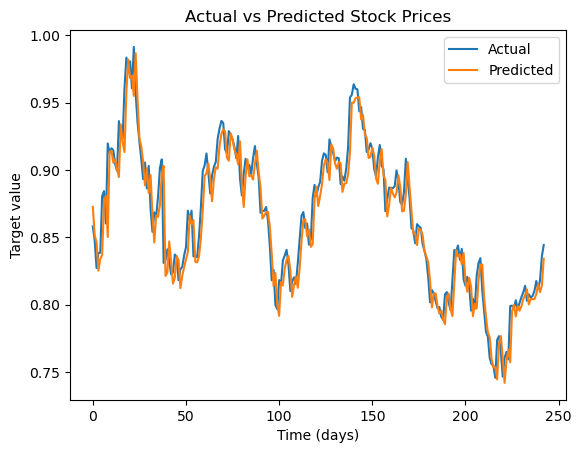

In [46]:
import matplotlib.pyplot as plt

# Make predictions on the testing data with the trained model
y_pred = model.predict(test_X)

# # Inverse transform the normalized data
# y_pred = scaler.inverse_transform(y_pred)
# # Reshape test_y to a 2D array
# test_y_2d = np.reshape(test_y, (-1, 1))

# # Inverse transform the normalized data
# y_pred = scaler.inverse_transform(y_pred)
# test_y = scaler.inverse_transform(test_y_2d)


# Plot the actual and predicted values
plt.plot(test_y, label='Actual')
plt.plot(test_predict, label='Predicted')

plt.xlabel('Time (days)')
plt.ylabel('Target value')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

In [43]:
loss = model.evaluate(test_X, test_y)

# print the loss value
print("Loss: {:.6f}".format(loss))

8/8 [==============================] - 0s 11ms/step - loss: 2.4740e-04
Loss: 0.000247


In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# assuming y_true and y_pred are the true and predicted labels, respectively
mse = mean_squared_error(test_y, y_pred)
mae = mean_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

MSE: 0.0002474038057244697
MAE: 0.011807667197926988
R-squared: 0.9091165631464124
RMSE: 0.015729075170666258
